# Spoken Language Processing 2023-24

# Lab3 - Dialogue Systems

_Bruno Martins_


This lab assignment will introduce tools and concepts related to the development of dialogue systems, exemplifying also the use of automatic speech recognition and text-to-speech models in this particular context.

Students will be tasked with the development of a simple (spoken/conversational) question answering system, reusing different models associated to the HuggingFace Transformers library:

* Speech recognition models (e.g., OpenAI Whisper).
* Large language models for natural language understanding and generation (e.g., [LaMini-GPT2](https://huggingface.co/MBZUAI/LaMini-GPT-124M) models).
* Text-to-speech models (e.g., SpeechT5).

The first parts of this notebook will guide students in the use of the tools, while the last part presents the main problem that is to be tackled. Note that the first parts also feature intermediate tasks, which students are required to solve.

To complete the project, student groups must deliver in Fenix an updated version of this notebook, featuring the proposed solutions to each task, together with a small PDF report (2 pages) outlining the methods that were developed (you can use the [following Overleaf template](https://www.overleaf.com/latex/templates/interspeech-2023-paper-kit/kzcdqdmkqvbr) for the report). The report can contain a section for each of the parts in the notebook, and the set of two documents should be uploaded in Fenix through a .zip file named after the number of the group.

Students are encouraged to modify examples, incorporate any other techniques, and in general explore any approach that may permit improving the results. Assessment will be based on task completion, creativity in the proposed solutions, and overall accuracy over a benchmark dataset.

### Group identification

Initialize the variable `group_id` with the number that Fenix assigned to your group and `student1_name`, `student1_id`, `student2_name` and `student2_id` with your names and student numbers.

In [55]:
group_id = 23
student1_name = "Daniele Avolio"
student1_id = 111559
student2_name = "Eduardo Da Paz Rodrigues"
student2_id = 111684


print(f"Group number: {group_id}")
print(f"Student 1: {student1_name} ({student1_id})")
print(f"Student 2: {student2_name} ({student2_id})")

Group number: 23
Student 1: Daniele Avolio (111559)
Student 2: Eduardo Da Paz Rodrigues (111684)


In [56]:
assert isinstance(group_id, int) and isinstance(student1_id, int) and isinstance(student2_id, int)
assert isinstance(student1_name, str) and isinstance(student2_name, str)
assert (group_id > 0) and (group_id < 40)
assert (student1_id > 60000) and (student1_id < 120000) and (student2_id > 60000) and (student2_id < 120000)

# Install and import Python packages

NumPy is a Python library that provides functions to process multidimensional arrays. The NumPy documentation is available [here](https://numpy.org/doc/1.24/).

[Librosa](https://librosa.org/) is a Python package for analyzing and processing audio signals. It provides a wide range of tools for tasks such as loading and manipulating audio files, extracting features from audio signals, and visualizing and playing back audio data.

IPython display is a module in the IPython interactive computing environment that provides a set of functions for displaying various types of media in the Jupyter notebook or other IPython-compatible environments. For example, you can use the display() function to display an object in a notebook cell (for example an audio object).

Matplotlib is a popular Python library that allows users to create a wide range of visualizations using a simple and intuitive syntax.

Huggingface transformers provides APIs and tools to easily download and train state-of-the-art pretrained models based on the Transformer architecture. The documentation is available [here](https://huggingface.co/docs/transformers/index) and, for more details, look at the official [HuggingFace course](https://huggingface.co/course/chapter1/1).

The associated HuggingFace libraries named [datasets](https://huggingface.co/docs/datasets/index) and [evaluate](https://huggingface.co/docs/evaluate/index) respectivly suport the direct access to many well-known datasets and common evaluation metrics used in NLP and speech research.

In [57]:
!pip3 install sentencepiece
!pip3 install xformers
!pip3 install transformers
!pip3 install datasets
!pip3 install evaluate
!pip3 install jiwer
!pip3 install librosa

In [58]:
import transformers
import datasets
import evaluate
import numpy as np
import librosa
import librosa.display
from IPython.display import Audio
from matplotlib import pyplot as plt

# Using OpenAI Whisper

Whisper is a cutting-edge model for for Automatic Speech Recognition (ASR), developed by OpenAI using a massive dataset of 680,000 hours of multilingual and multitask supervised data collected from the internet, and made available through the HuggingFace Transformers library.

The following example illustrates the use of the Whisper model to transcribe a small audio sample taken from the LibriSpeech dataset (which is available through the HuggingFace datasets library).

More detailed information about Whisper, including information on how to fine-tune the model with task-specific data, is available on a [tutorial in the HuggingFace blog](https://huggingface.co/blog/fine-tune-whisper).

In [59]:
import torch
import librosa
from transformers import AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

audio = ds[0]["audio"]["array"]
audio = librosa.resample(audio, orig_sr=16000, target_sr=16000) # Resample audio to 16kHz (not needed in the case of this dataset)

inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
input_features = inputs.input_features

display(Audio(audio, rate=16000)) # You are able to hear the audio inputs

generated_ids = model.generate(inputs=input_features)
transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]

print(transcription)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for hf-internal-testing/librispeech_asr_dummy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/hf-internal-testing/librispeech_asr_dummy
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:474: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.


Automatic Speech Recognition (ASR) models are frequently evaluated through the Word Error Rate ([WER](https://huggingface.co/spaces/evaluate-metric/wer)).

The WER is derived from the Levenshtein distance, working at the word level and aligning the recognized word sequence with the reference (spoken) word sequence using dynamic string alignment. The metric can then be computed as:

WER = (S + D + I) / N = (S + D + I) / (S + D + C),

where S is the number of substitutions, D is the number of deletions, I is the number of insertions, C is the number of correct words, and N is the number of words in the reference (N=S+D+C). The WER value indicates the average number of errors per reference word. The lower the value, the better the performance of the ASR system, with a WER of 0 being a perfect score.

The example below illustrates the computation of the WER for two paired examples of a generated sentence versus a reference sentence. The score produced as output is the average value accross the two examples.

In [60]:
from evaluate import load

wer = load("wer")
predictions = ["this is the prediction", "there is an other sample"]
references = ["this is the reference", "there is another one"]
wer_score = wer.compute(predictions=predictions, references=references)

print(wer_score)

0.5


## Intermediate tasks:

* Collect two small audio samples with your own voice, together with a transcription of the spoken messages. The following [example shows how to record audio from your microphone within a Python notebook running on Google Colab](https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb#scrollTo=H4rxNhsEpr-c), but you can use any other method to collect the audio samples.
* Use the Whisper speech recognition model to transcribe the two spoken messages that were collected.
* Use the transcriptions to compute the word error rate.
* Experiment with the use of different recognition models (e.g., larger Whisper models), and see if the error rate changes.

**Notebook audio recording setup**

In [61]:
!pip install ffmpeg-python

In [62]:
# """
# To write this piece of code I took inspiration/code from a lot of places.
# It was late night, so I'm not sure how much I created or just copied o.O
# Here are some of the possible references:
# https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
# https://stackoverflow.com/a/18650249
# https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
# https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
# https://stackoverflow.com/a/49019356
# """
# from IPython.display import HTML, Audio
# from google.colab.output import eval_js
# from base64 import b64decode
# import numpy as np
# from scipy.io.wavfile import read as wav_read
# import io
# import ffmpeg

# AUDIO_HTML = """
# <script>
# var my_div = document.createElement("DIV");
# var my_p = document.createElement("P");
# var my_btn = document.createElement("BUTTON");
# var t = document.createTextNode("Press to start recording");

# my_btn.appendChild(t);
# //my_p.appendChild(my_btn);
# my_div.appendChild(my_btn);
# document.body.appendChild(my_div);

# var base64data = 0;
# var reader;
# var recorder, gumStream;
# var recordButton = my_btn;

# var handleSuccess = function(stream) {
#   gumStream = stream;
#   var options = {
#     //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
#     mimeType : 'audio/webm;codecs=opus'
#     //mimeType : 'audio/webm;codecs=pcm'
#   };
#   //recorder = new MediaRecorder(stream, options);
#   recorder = new MediaRecorder(stream);
#   recorder.ondataavailable = function(e) {
#     var url = URL.createObjectURL(e.data);
#     var preview = document.createElement('audio');
#     preview.controls = true;
#     preview.src = url;
#     document.body.appendChild(preview);

#     reader = new FileReader();
#     reader.readAsDataURL(e.data);
#     reader.onloadend = function() {
#       base64data = reader.result;
#       //console.log("Inside FileReader:" + base64data);
#     }
#   };
#   recorder.start();
#   };

# recordButton.innerText = "Recording... press to stop";

# navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


# function toggleRecording() {
#   if (recorder && recorder.state == "recording") {
#       recorder.stop();
#       gumStream.getAudioTracks()[0].stop();
#       recordButton.innerText = "Saving the recording... pls wait!"
#   }
# }

# // https://stackoverflow.com/a/951057
# function sleep(ms) {
#   return new Promise(resolve => setTimeout(resolve, ms));
# }

# var data = new Promise(resolve=>{
# //recordButton.addEventListener("click", toggleRecording);
# recordButton.onclick = ()=>{
# toggleRecording()

# sleep(2000).then(() => {
#   // wait 2000ms for the data to be available...
#   // ideally this should use something like await...
#   //console.log("Inside data:" + base64data)
#   resolve(base64data.toString())

# });

# }
# });

# </script>
# """

# def get_audio():
#   display(HTML(AUDIO_HTML))
#   data = eval_js("data")
#   binary = b64decode(data.split(',')[1])

#   process = (ffmpeg
#     .input('pipe:0')
#     .output('pipe:1', format='wav')
#     .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
#   )
#   output, err = process.communicate(input=binary)

#   riff_chunk_size = len(output) - 8
#   # Break up the chunk size into four bytes, held in b.
#   q = riff_chunk_size
#   b = []
#   for i in range(4):
#       q, r = divmod(q, 256)
#       b.append(r)

#   # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
#   riff = output[:4] + bytes(b) + output[8:]

#   sr, audio = wav_read(io.BytesIO(riff))

#   return audio, sr

In [63]:
# audio, sr = get_audio() # Only if colab

# print(f"SR:  {sr}")
# print(f"Audio: {audio}")

In [64]:
audio1, sr = librosa.load("recordings/Audio1.m4a", sr=None)
audio2, sr = librosa.load("recordings/Audio2.m4a", sr=None)

display(Audio(audio1, rate=sr)) # Audio recording 1
display(Audio(audio2, rate=sr)) # Audio recording 2


<ipython-input-64-907e1fa80a48>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  audio1, sr = librosa.load("recordings/Audio1.m4a", sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
<ipython-input-64-907e1fa80a48>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio2, sr = librosa.load("recordings/Audio2.m4a", sr=None)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Actual task implemented here

In [65]:
audio = np.asarray(audio1, dtype=np.float32)
audio2 = np.asarray(audio2, dtype=np.float32)

myAudio = librosa.resample(audio, orig_sr=sr, target_sr=16000)
myAudio2 = librosa.resample(audio2, orig_sr=sr, target_sr=16000)


inputs = processor(myAudio, sampling_rate=16000, return_tensors="pt")
input_features = inputs.input_features

inputs2 = processor(myAudio2, sampling_rate=16000, return_tensors="pt")
input_features2 = inputs2.input_features


display(Audio(myAudio, rate=16000)) # You are able to hear the audio inputs
display(Audio(myAudio2, rate=16000)) # You are able to hear the audio inputs

ids1 = model.generate(inputs=input_features)
ids2 = model.generate(inputs=input_features2)

transcription1 = [processor.batch_decode(ids1, max_length=250, skip_special_tokens=True)[0]]
transcription2 = [processor.batch_decode(ids2, max_length=250, skip_special_tokens=True)[0]]

ref = ["Whatever it takes, we will finish this project.", "I've been in Lisbon since February and I'll go back in Italy in July."]
print(f" Transcription 1: {transcription1}")
print(f" Transcription 2: {transcription2}")

transcription = transcription1 + transcription2

print(f" Actual phrase: {ref}")

wer_score = wer.compute(predictions=transcription, references=ref)

print(wer_score)


/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:474: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


 Transcription 1: [' Whatever it takes, we will finish this project.']
 Transcription 2: [" I've been in Lisbon since February and I'll go back in Italy in July."]
 Actual phrase: ['Whatever it takes, we will finish this project.', "I've been in Lisbon since February and I'll go back in Italy in July."]
0.0


We did some audio recording from the notebook microphone and it was so bad that the predictions were 100% wrong.

# Using LLMs for conditional language generation

OpenAI GPT-2 is a language model based on the Transformer decoder architecture, trained with large scale data collected from the Web using a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains. Thus, GPT-2 can be used to address problems like question answering, modeling the task as language generation conditioned in the question (plus other relevant additional context).

The following example illustrates the use of the GPT-2 through the Huggingface Transformers library. In this case, instead of using the model directly, we are using the model through the pipeline API, which facilitates the adaptation to the case of other LLMs. The pipeline() function can be used to connect a model with its necessary preprocessing and postprocessing steps, allowing us to directly input any text and get an intelligible answer.

In [66]:
from transformers import pipeline, set_seed

set_seed(42) # make results deterministic

generator = pipeline(model='gpt2')
generator("Who is the president of the United States? The answer is", max_length=15, num_return_sequences=1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Who is the president of the United States? The answer is: Hillary Clinton'}]

## Intermediate tasks:

* Adapt the example showing how to use GPT-2 to do question answering over the [TriviaQA dataset](http://nlp.cs.washington.edu/triviaqa/) (you can use a [version](https://huggingface.co/datasets/lucadiliello/triviaqa) of this dataset from a previous shared task, which is available from HuggingFace datasets).
* Evaluate the results obtained with different models (e.g., relatively small models trained to follow instructions, for instance from the [LaMini-LM](https://huggingface.co/MBZUAI/LaMini-GPT-124M) family, or quantized versions of larger models such as [Meta Llama 3](https://huggingface.co/meta-llama/Meta-Llama-3-8B)) and/or different usage strategies (e.g., consider different prompting strategies, parameter efficient fine-tuning, etc.).
* Compute the error over the first 1000 examples from the validation split from the TriviaQA dataset, using the [BLEU metric](https://huggingface.co/spaces/evaluate-metric/bleu) for comparing the generated answers against the ground truth.


In [67]:
# Get the dataset

dataset = load_dataset("lucadiliello/triviaqa")

In [68]:
# Let's see some data

t = 'validation'


pruned_ds = [dataset[t][i]for i in range(10)]

answers = [dataset[t][i]['answers'] for i in range(10)]
questions = [dataset[t][i]['question'] for i in range(10)]


print(dataset[t][0].keys())
model_answers = []
try:
  model_answers = [generator(f"""Answer the Question based on the Context and keep the Answer very short and straightforward \n Context: {row['context']} \n Question: {row['question']} \n Answer: The answer is:""", num_return_sequences=1,max_new_tokens=30 ) for row in pruned_ds]
except:
  print("Error in the model")
  print("Probably the question length is too long!")

print("Model answers: ", model_answers)




Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


dict_keys(['context', 'question', 'answers', 'key', 'labels'])


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Token indices sequence length is longer than the specified maximum sequence length for this model (1088 > 1024). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Error in the model
Probably the question length is too long!
Model answers:  []


This strategy is not working because sometimes the context is too big and the model is not able to generate the answer.

**Testing with Roberta Model**

No, we cant use Roberta because it's encoder extracting approach so no.

In [120]:
pruned_ds = [dataset[t][i]for i in range(10)]

answers = [dataset[t][i]['answers'] for i in range(10)]
questions = [dataset[t][i]['question'] for i in range(10)]


In [70]:
# Use a pipeline as a high-level helper
from transformers import pipeline

# fine-tune the model on the triviaqa dataset
pipe = pipeline("text2text-generation", model="MBZUAI/LaMini-T5-738M")


In [79]:
# Check if GPU is available
print("GPU available: ", torch.cuda.is_available())

# If GPU is available, set the device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pipeline to gpu
pipe.model.to(device)


GPU available:  True


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [121]:
lamini_answers = []

for row in pruned_ds:

    instruction = f"""
    Briefly answer to this question keeping the text under 5 words. \n
    {row['question']}. \n
    Context: {row['context']} \n
    """

    # Ensure the input is on the correct device
    inputs = pipe.tokenizer(instruction, return_tensors="pt").to(device)

    # Generate response with constraints for short length
    outputs = pipe.model.generate(
        **inputs,
        num_return_sequences=1,
        num_beams=1,  # Use beam search for better responses
        max_new_tokens=30,
    )

    # Move the outputs back to CPU if necessary for further processing
    outputs = outputs.cpu()

    # print input
    print(f"Input: {instruction}")

    # Decode the output and append it to the list
    lamini_answers.append(pipe.tokenizer.decode(outputs[0], skip_special_tokens=True))



Input: 
    Briefly answer to this question keeping the text under 5 words. 

    Who had an 80s No 1 hit with Hold On To The Nights?. 

    Context: [DOC] [TLE] Hold On to the Nights"Hold On to the Nights" is a power ballad and number-one hit for American rock singer/songwriter/musician Richard Marx.  This was the fourth and final single released from his self-titled debut album, and the first to reach the top of the Billboard Hot 100 chart. [PAR] Written by Richard Marx, "Hold On to the Nights" reached the Billboard Hot 100 number 1 position on July 23, 1988, preventing Def Leppard's "Pour Some Sugar On Me" from reaching the top spot that same week. The song was on the chart for twenty-one weeks, and left the chart at number 65. From Marx' debut 1987 album, Richard Marx, the song also reached number three on the Billboard Adult Contemporary chart. "Hold On to the Nights" has been re-released numerous albums  and is included on Marx's live performance DVD A Night Out with Friends (201

In [122]:
for i in range(10):
    print("Question: ", pruned_ds[i]['question'])
    print("Answer: ", answers[i])
    print("LaMini Answer: ", lamini_answers[i])
    print("")

Question:  Who had an 80s No 1 hit with Hold On To The Nights?
Answer:  ['richard marx']
LaMini Answer:  Richard Marx had an 80s No 1 hit with "Hold On to the Nights".

Question:  What is the Japanese share index called?
Answer:  ['nikkei']
LaMini Answer:  The Japanese share index is called the Nikkei.

Question:  Who had a 70s No 1 hit with Kiss You All Over?
Answer:  ['exile']
LaMini Answer:  The song "Kiss You All Over" had a 70s No 1 hit.

Question:  Kagoshima international airport is in which country?
Answer:  ['japan']
LaMini Answer:  Kagoshima International Airport is located in Japan.

Question:  What was Eddie Murphy's first movie?
Answer:  ['48 hours']
LaMini Answer:  The text does not provide information about Eddie Murphy's first movie.

Question:  Which musician founded the Red Hot Peppers?
Answer:  ['jelly roll morton']
LaMini Answer:  The musician who founded the Red Hot Peppers was Jelly Roll Morton.

Question:  Kim Carnes' nine weeks at No 1 with Bette Davis Eyes was i

In [123]:

import evaluate

bleu2 = evaluate.load("bleu")

# Compute BLEU score
print("Shapes: ", len(lamini_answers), len(answers))
results = bleu2.compute(predictions=lamini_answers, references=answers, max_order=2)


Shapes:  10 10


In [124]:
print(results)

{'bleu': 0.010803395392536072, 'precisions': [0.014705882352941176, 0.007936507936507936], 'brevity_penalty': 1.0, 'length_ratio': 6.8, 'translation_length': 136, 'reference_length': 20}


**Roberta works nice!**

Since Roberta model is working well for short answers, we will use this.

Let's get the entire 1000 examples now.

In [77]:
# t = 'validation'
# real_validation = [dataset[t][i]for i in range(1000)]

# answers = [dataset[t][i]['answers'] for i in range(1000)]

# roberta_evaluation = []

# for row in real_validation:
#     QA_input = {
#         'question': row['question'] + "Answer with a short and concise answer",
#         'context': row['context']
#     }
#     roberta_evaluation.append(nlp(QA_input)['answer'].lower())

# # Do bleu score
# results = bleu2.compute(predictions=roberta_evaluation, references=answers, max_order=2)

# print(results)

NameError: name 'nlp' is not defined

In [ ]:
# # To be safe, let's create a csv containing the results

# import pandas as pd

# # save the questions and answers
# df = pd.DataFrame({"question": questions, "roberta": roberta_answers, "answers": answers})
# df.to_csv("roberta_answers.csv", index=False)

# # save the results
# df = pd.DataFrame({"BLEU": results})
# df.to_csv("bleu_roberta_res.csv", index=False)





# Using SpeechT5 for converting text-to-speech

Motivated by the success of T5 (Text-To-Text Transfer Transformer) in different natural language processing tasks, the unified-modal SpeechT5 framework explores encoder-decoder pre-training for self-supervised speech/text representation learning.

The model is again conveniently available through the HuggingFace Transformers library. The following example illustrates the use of the SpeechT5 model for generating a spectrogram from a textual input, together with a neural vocoder model for producing a speech signal.

More detailed information about SpeechT5 is available on a [tutorial on the HuggingFace blog](https://huggingface.co/blog/speecht5).

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/7931 [00:00<?, ? examples/s]

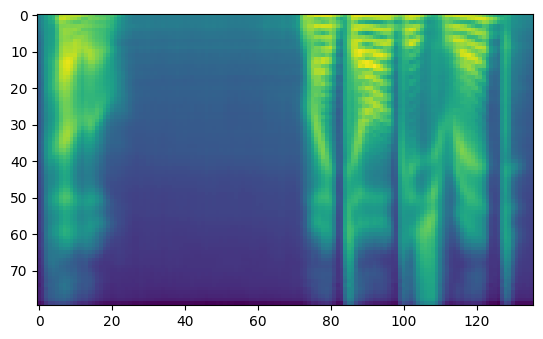

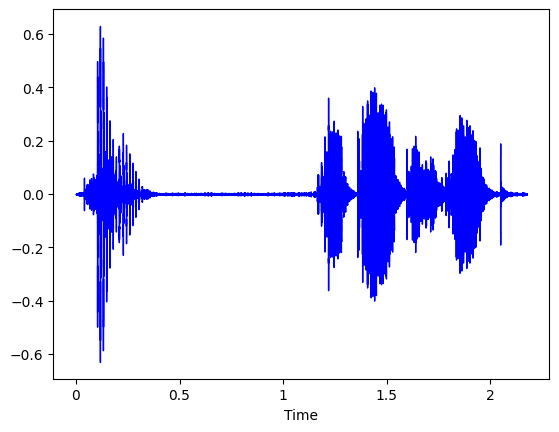

In [125]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed
from IPython.display import Audio
from datasets import load_dataset
import soundfile as sf
import librosa
import torch

set_seed(42) # make results deterministic

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

inputs = processor(text="Hello, my dog is red.", return_tensors="pt")
speaker_embeddings = torch.zeros((1, 512))

# When using SpeechT5 for TTS, you should use "xvector speaker embeddings"
# to customize the output to a particular speaker’s voice characteristics
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
with torch.no_grad(): speech = vocoder(spectrogram)

display(Audio(speech.numpy(), rate=16000)) # You can hear the audio inputs

# You can plot the generated spectrogram
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

librosa.display.waveshow(speech.numpy(), sr=16000, color="blue") # You can plot the generated waveform

sf.write("tts_example.wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file

As professor said, we should use the same symbol that were used on the training.
A tip is that the model don't know how to pronunce digits, so we should keep this in mind.

## Intermediate tasks:

* Connect the results from your answer to the previous intermediate task (i.e., conditioned language generation) to the SpeechT5 text-to-speech model, so as to produce speech outputs from the text generated by the model.
* Produce speech-based answers for the first 5 questions in the validation split from the TriviaQA dataset.
* Connect also the results from your answer to the first intermediate task (i.e., automated speech recognition) to the SpeechT5 model and the LLM, so as to take spoken questions as input and produce a speech output.
* Take the audio samples from 10 TriviaQA questions (as available in connection to the [SLUE-SQA-5 dataset](https://huggingface.co/datasets/asapp/slue-phase-2), in Huggingface datasets), and evaluate the answers generated for the spoken questions using the BLEU metric.
* Collect small audio samples, with your own voice, for the first 2 questions in the validation split from the TriviaQA dataset, and produce speech-based answers for these two questions.


In [126]:
# Take the first 5 answers from the validation set given by the model
answers = [lamini_answers[i] for i in range(5)]

# Generate the audio for each answer

import os
os.makedirs("tts_examples", exist_ok=True)


for i, answer in enumerate(answers):
    inputs = processor(text=answer, return_tensors="pt")
    speaker_embeddings = torch.zeros((1, 512))
    spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
    with torch.no_grad(): speech = vocoder(spectrogram)
    sf.write(f"tts_examples/tts_{i}.wav", speech.numpy(), samplerate=16000)

# Let's listen to the audios
for i in range(5):
    display(Audio(f"tts_examples/tts_{i}.wav"))



In [128]:
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=95feccd6b625270a7b6ae98dbf4e97cdeb74025aa9e163ac7e6a678dec9213bf
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [161]:
from datasets import load_dataset
from converter import convert_text

url = "https://datasets-server.huggingface.co/first-rows?dataset=asapp%2Fslue-phase-2&config=sqa5&split=validation&offset=0&length=20"

def query(url):
    response = requests.get(url)
    return response.json()

data = query(url)



In [174]:
os.makedirs("questions", exist_ok=True)

count = 0
for r in data['rows']:
  audio = requests.get((r['row']['question_audio'][0]['src']))
  with open(f'questions/{count}.wav', 'wb') as file:
        file.write(audio.content)
        count+=1


In [179]:
audios = []
for i in range(10):
  audio, sr = librosa.load(f"questions/{i}.wav", sr=None)
  audios.append(audio)

In [197]:
contexts = []

for r in data['rows']:
  context = r['row']['raw_document_text']
  contexts.append(context)

In [198]:
print(contexts)

['. Edgar the Ætheling also appears to have been given lands . Ecclesiastical offices continued to be held by the same bishops as before the invasion , including the uncanonical Stigand . But the families of Harold and his brothers did lose their lands , as did some others who had fought against William at Hastings . By March , William was secure enough to return to Normandy , but he took with him Stigand , Morcar , Edwin , Edgar , and Waltheof . He left his half-brother Odo , the Bishop of Bayeux , in charge of England along with another influential supporter ,', 'form ( allotrope ) of oxygen , ozone ( O 3 ) , helps protect the biosphere from ultraviolet radiation with the high-altitude ozone layer , but is a pollutant near the surface where it is a by-product of smog . Oxygen was independently discovered by Joseph Priestley in Wiltshire , in 17 hundred 74 , and Carl Wilhelm Scheele , in Uppsala , a year earlier , but Priestley is usually given priority because he published his findin

In [230]:
questions_answers = []
for r in data['rows']:
  answer = r['row']['answer_spans']['answer'][0]
  questions_answers.append(answer)


In [231]:
print(questions_answers)

['normandy', 'allotrope', 'isotope', '11,000 years', 'united methodist church', '2014', 'labour', 'three', 'angina', 'mantle', 'reason', 'solution', 'last mission', 'all', 'two', 'edward teller', 'grover cleveland', 'galileo galilei', 'lymphocytes', 'two', 'four', 'england', '2002', 'four', 'norman', 'six', '60', '9 march 1508', 'public order', 'presbyterian', 'april 1523', 'the supreme court', 'water', 'catholic', 'guinness world records', 'antoine lavoisier', 'sunlight', 'np', '40,000', '1534', 'jewish', 'catholicism', 'japan', 'the song dynasty']


In [225]:
from transformers import AutoModelForSpeechSeq2Seq

# Let's convert the audios to text
questions_text = []
processor = AutoProcessor.from_pretrained("openai/whisper-medium.en")
model = AutoModelForSpeechSeq2Seq.from_pretrained("openai/whisper-medium.en")


for i, audio in enumerate(audios):
    myAudio = np.asarray(audio, dtype=np.float32)
    myAudio = librosa.resample(myAudio, orig_sr=sr, target_sr=16000)
    inputs = processor(myAudio, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features
    generated_ids = model.generate(inputs=input_features)
    transcription = processor.batch_decode(generated_ids, max_length=500, skip_special_tokens=True)[0]
    # This is done to convert the numbers to text
    text = convert_text(transcription)
    questions_text.append(text)

config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.06G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/1.95k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:474: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


In [226]:
for q in questions_text:
  print(q)

To where did Ethel read flee? 
Of what is ozone a reactive part of oxygen? 
What type of ratios are used in geochronological and thermo-chronological studies? 
For how many years was evidence shown that humans shaped the Amazon? 
What church is organized into conferences? 
Which year resulted in the suspension of one of the two soccer teams? 
Who did the S, N, P obtain sixteen seats from? 
How many main flows are branched off from the nitrogen? 
By 1544, what did Luther have to deal with in his health? 
In the layered model of the Earth, their seismic discontinuity is in which layer? 


In [235]:
# Now we feed the questions to the model

new_answers = []

for i, question in enumerate(questions_text):
    instruction = f"""
    {contexts[i]} \n {question}"""

    prompt = f"""
    Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
    """

    print(f"Context:{contexts[i]}")
    print(f"Question:{question}")
    inputs = pipe.tokenizer(instruction, return_tensors="pt").to(device)
    outputs = pipe.model.generate(
        **inputs,
        num_return_sequences=1,
        num_beams=5,
        max_new_tokens=50,
    )
    outputs = outputs.cpu()
    new_answers.append(pipe.tokenizer.decode(outputs[0], skip_special_tokens=True))




Context:. Edgar the Ætheling also appears to have been given lands . Ecclesiastical offices continued to be held by the same bishops as before the invasion , including the uncanonical Stigand . But the families of Harold and his brothers did lose their lands , as did some others who had fought against William at Hastings . By March , William was secure enough to return to Normandy , but he took with him Stigand , Morcar , Edwin , Edgar , and Waltheof . He left his half-brother Odo , the Bishop of Bayeux , in charge of England along with another influential supporter ,
Question:To where did Ethel read flee? 
Context:form ( allotrope ) of oxygen , ozone ( O 3 ) , helps protect the biosphere from ultraviolet radiation with the high-altitude ozone layer , but is a pollutant near the surface where it is a by-product of smog . Oxygen was independently discovered by Joseph Priestley in Wiltshire , in 17 hundred 74 , and Carl Wilhelm Scheele , in Uppsala , a year earlier , but Priestley is usu

In [229]:
print(len(questions_answers), len(new_answers))

0 10


In [238]:
for i in range(10):
  print(f"Model ans: {new_answers[i]}")
  print(f"Real ans: {questions_answers[i]}")

Model ans: None of the above choices. The passage does not provide information about where Ethel read fled to.
Real ans: normandy
Model ans: The ozone is a reactive part of oxygen because it helps protect the biosphere from ultraviolet radiation with the high-altitude ozone layer, but is a pollutant near the surface where it is a by-product
Real ans: allotrope
Model ans: Isotope ratios are used in geochronological and thermo-chronological studies.
Real ans: isotope
Model ans: The evidence showed that humans shaped the Amazon around 11,000 years ago.
Real ans: 11,000 years
Model ans: The passage does not provide information about a church that is organized into conferences. Therefore, the answer is "None of the above choices."
Real ans: united methodist church
Model ans: There is no information provided in the given text about the suspension of one of the two soccer teams. Therefore, the answer is "None of the above choices."
Real ans: 2014
Model ans: The S, N, P obtained sixteen seats 

In [219]:
# Now we do BLEU score
results = bleu2.compute(predictions=new_answers, references=questions_answers[:10], max_order=2)
print(results)


{'bleu': 0.0, 'precisions': [0.014150943396226415, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 16.307692307692307, 'translation_length': 212, 'reference_length': 13}


In [239]:
#Now we get audios for the first 2 questions from the validation set
q1,sr = librosa.load(f"recordings/question1.mp3", sr=None)
q2,sr  = librosa.load(f"recordings/question2.mp3", sr=None)

audios2=[q1,q2]
# Let's convert the audios to text
validation_questions_text = []

for i, audio in enumerate(audios2):
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features
    generated_ids = model.generate(inputs=input_features)
    transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]
    # This is done to convert the numbers to text
    text = convert_text(transcription)
    validation_questions_text.append(text)


/usr/local/lib/python3.10/dist-packages/transformers/models/whisper/generation_whisper.py:474: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


In [ ]:

# Now we feed the questions to the model

validation_answers = []

for i, question in enumerate(validation_questions_text):
    instruction = f"""Answer this question using the context. \n Question: {question} \n Context: {pruned_ds[i]['context']} \n Answer: """
    prompt = f"""
    Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"
    """
    inputs = pipe.tokenizer(instruction, return_tensors="pt").to(device)
    outputs = pipe.model.generate(
        **inputs,
        num_return_sequences=1,
        num_beams=1,  # Use beam search for better responses
        max_new_tokens=30,
    )
    outputs = outputs.cpu()

    # Convert numbers into text using the custom function
    text = convert_text(pipe.tokenizer.decode(outputs[0], skip_special_tokens=True))

    validation_answers.append(text)


# Now we create audios for the answers

answers_audios = []


model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)


for i, answer in enumerate(validation_answers):
    inputs = processor(text=answer, return_tensors="pt")
    speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)
    spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
    with torch.no_grad(): speech = vocoder(spectrogram)
    answers_audios.append(speech)

# Let's listen to the audios
for i in range(2):
    display(Audio(answers_audios[i].numpy(), rate=16000))


# Main problem

Students are tasked with joining together the speech recognition, language understanding and generation, and text-to-speech models, in order to build a conversational spoken question answering approach.

* The method should take as input speech utterances with questions.
* The language understanding and generation component should use as input a transcription for the current speech utterance, and optionally also transcriptions from previous speech utterances (i.e., the conversation context).
* The language understanding and generation component can explore different strategies for improving answer quality:
  * Use of large LLMs trained to follow instructions, e.g. with reinforcement learning from human feedback.
  * Prompting the language model with retrieved in-context examples.
  * Using parameter-efficient fine-ting with existing conversational question answering datasets (e.g., [the CoQA dataset](https://stanfordnlp.github.io/coqa/), which is [also available](https://huggingface.co/datasets/stanfordnlp/coqa) from HuggingFace datasets).
  * ...
* The text-to-speech component takes as input the results from language generation, and produces a speech output.
* Both the automated speech recognition and the text-to-speech components can explore different approaches, although students should attempt to justify their choices (e.g., if changing the automated speech recognition component, show that it achieves a lower WER).
* Collect small audio samples, with your own voice, for the questions in the first instance in the CoQA validation split, and show the results produced by your method for these questions.

In [ ]:
# Add your solutions to the exercises